In [0]:
!kill -9 -1

In [1]:
ls

sample_data/


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!cp /content/gdrive/My\ Drive/drivable/BDD.zip .

In [0]:
!unzip -q BDD.zip

In [0]:
%matplotlib inline
import os
import cv2
import glob
import matplotlib.pyplot as plt
import random
import numpy as np

In [0]:
def detail_images(image_file, label_file):
    
    print('Image file:', image_file.split('/')[-1])
    print('Label file:', label_file.split('/')[-1])
    
    train_img = plt.imread(image_file)
    label_img = cv2.imread(label_file, 0)
    color_img = np.zeros(train_img.shape, np.uint8)

    # Light yellow [255, 255, 0] alternate
    # Light green [124, 252, 0] drivable
    
    color_img[label_img == 2] = [255, 255, 0]
    color_img[label_img == 1] = [124, 252, 0]          
    
            
    print('Shapes of train, label, color:', 
          train_img.shape, label_img.shape, color_img.shape)
    print('Dtype of train, label, color:', 
          train_img.dtype, label_img.dtype, color_img.dtype)
    print('Max values of train, label, color:', 
         np.max(train_img), np.max(label_img), np.max(color_img))
    print('Min values of train, label, color:', 
         np.min(train_img), np.min(label_img), np.min(color_img)) 
    
    unique = np.unique(label_img)
    
    print('Classes in image:', unique)

    plt.figure(figsize=(9, 14))

    plt.subplot(3,1,1)
    plt.imshow(train_img)
    plt.axis('off')

    plt.subplot(3,1,2)
    plt.imshow(label_img)
    plt.axis('off')

    plt.subplot(3,1,3)
    plt.imshow(color_img)
    plt.axis('off')    
    
    plt.show()

No of images and Labels: 70000 70000
Index: 29908
Image file: 4c71b5eb-bc4e6713.jpg
Label file: 4c71b5eb-bc4e6713_drivable_id.png
Shapes of train, label, color: (720, 1280, 3) (720, 1280) (720, 1280, 3)
Dtype of train, label, color: uint8 uint8 uint8
Max values of train, label, color: 255 2 255
Min values of train, label, color: 0 0 0
Classes in image: [0 1 2]


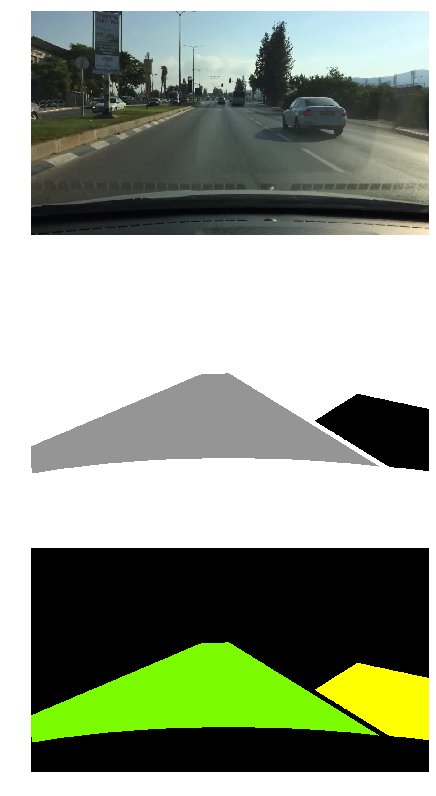

In [7]:
images_train = sorted(glob.glob('BDD/train/images/*'))
labels_train = sorted(glob.glob('BDD/train/labels/*'))

print('No of images and Labels:', len(images_train), len(labels_train))

idx = random.randint(0, len(images_train))
idx = 29908
print('Index:', idx)

detail_images(images_train[idx], labels_train[idx])

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Lambda, Conv2D, Add, AveragePooling2D, ZeroPadding2D 
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D, Activation, Input
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical, Sequence
import os
import glob
import random
import json
import gc
import numpy as np
import cv2
import pickle

In [0]:
def get_class_weights():
    if os.path.isfile('class_weights.p'):
        class_weights = pickle.load(open("class_weights.p", "rb"))
    else:
        class_weights_arr = np.zeros(3)
        labels_list = sorted(glob.glob('BDD/train/labels/*'))

        for idx in range(len(labels_list)):
            img_weights = np.zeros(3)
            img = cv2.imread(labels_list[idx], 0)
            img = cv2.resize(img, (640, 320))
            for i in range(3):
                img_weights[i] = (img == i).sum()
            img_weights = img_weights/921600
            class_weights_arr += img_weights
            
        class_weights_arr /= len(labels_list)
        
        class_weights = {}
        
        for i in range(3):
            class_weights[i] = class_weights_arr[i]
            
        pickle.dump(class_weights, open("class_weights.p", "wb"))
        
    return class_weights   

In [0]:
class DataGenerator(Sequence):
    def __init__(self, folder='BDD', mode='train', n_classes=3, batch_size=1, 
                 resize_shape=(640, 320), brightness=0.1):

        self.image_path_list = sorted(glob.glob(os.path.join(folder, mode, 'images/*')))
        self.label_path_list = sorted(glob.glob(os.path.join(folder, mode, 'labels/*')))
        self.mode = mode
        self.n_classes = n_classes
        self.batch_size = batch_size
        self.resize_shape = resize_shape
        self.brightness = brightness

        # Preallocate memory

        self.X = np.zeros((batch_size, resize_shape[1], resize_shape[0], 3), dtype='float32')
        self.Y1 = np.zeros(
            (batch_size, resize_shape[1]//4, resize_shape[0]//4, self.n_classes), dtype='float32')
        self.Y2 = np.zeros(
            (batch_size, resize_shape[1]//8, resize_shape[0]//8, self.n_classes), dtype='float32')
        self.Y3 = np.zeros(
            (batch_size, resize_shape[1]//16, resize_shape[0]//16, self.n_classes), dtype='float32')


    def __len__(self):
        return len(self.image_path_list) // self.batch_size

    def __getitem__(self, i):
        for n, (image_path, label_path) in enumerate(zip(self.image_path_list[i*self.batch_size:(i+1)*self.batch_size],
                                                         self.label_path_list[i*self.batch_size:(i+1)*self.batch_size])):

            image = cv2.imread(image_path, 1)
            label = cv2.imread(label_path, 0)
            
            image = cv2.resize(image, self.resize_shape)
            label = cv2.resize(label, self.resize_shape)

            # Do augmentation (only if training)
            if self.mode == 'train':
                if self.brightness:
                    factor = 1.0 + abs(random.gauss(mu=0.0, sigma=self.brightness))
                    if random.randint(0, 1):
                        factor = 1.0/factor
                    table = np.array([((i / 255.0) ** factor) *
                                      255 for i in np.arange(0, 256)]).astype(np.uint8)
                    image = cv2.LUT(image, table)

            self.X[n] = image
            self.Y1[n] = to_categorical(cv2.resize(label, (label.shape[1]//4, label.shape[0]//4)),
                                        self.n_classes).reshape((label.shape[0]//4, label.shape[1]//4, -1))
            self.Y2[n] = to_categorical(cv2.resize(label, (label.shape[1]//8, label.shape[0]//8)),
                                        self.n_classes).reshape((label.shape[0]//8, label.shape[1]//8, -1))
            self.Y3[n] = to_categorical(cv2.resize(label, (label.shape[1]//16, label.shape[0]//16)),
                                        self.n_classes).reshape((label.shape[0]//16, label.shape[1]//16, -1))

        return self.X, [self.Y1, self.Y2, self.Y3]

    def on_epoch_end(self):
        # Shuffle dataset for next epoch
        c = list(zip(self.image_path_list, self.label_path_list))
        random.shuffle(c)
        self.image_path_list, self.label_path_list = zip(*c)

        # Fix memory leak (Keras bug)
        gc.collect()
        
class PolyDecay:
    def __init__(self, initial_lr, power, n_epochs):
        self.initial_lr = initial_lr
        self.power = power
        self.n_epochs = n_epochs

    def scheduler(self, epoch):
        return self.initial_lr * np.power(1.0 - 1.0*epoch/self.n_epochs, self.power)         

In [0]:
def ICNET(width, height, n_classes, weights_path=None, train=False):
    inp = Input(shape=(height, width, 3))
    x = Lambda(lambda x: (x - 127.5)/255.0)(inp)

    # (1/2)
    y = Lambda(lambda x: tf.image.resize_bilinear(x, size=(int(x.shape[1])//2, int(x.shape[2])//2), align_corners=True), name='data_sub2')(x)
    y = Conv2D(32, 3, strides=2, padding='same', activation='relu', name='conv1_1_3x3_s2')(y)
    y = BatchNormalization(name='conv1_1_3x3_s2_bn')(y)
    y = Conv2D(32, 3, padding='same', activation='relu', name='conv1_2_3x3')(y)
    y = BatchNormalization(name='conv1_2_3x3_s2_bn')(y)
    y = Conv2D(64, 3, padding='same', activation='relu', name='conv1_3_3x3')(y)
    y = BatchNormalization(name='conv1_3_3x3_bn')(y)
    y_ = MaxPooling2D(pool_size=3, strides=2, name='pool1_3x3_s2')(y)
    
    y = Conv2D(128, 1, name='conv2_1_1x1_proj')(y_)
    y = BatchNormalization(name='conv2_1_1x1_proj_bn')(y)
    y_ = Conv2D(32, 1, activation='relu', name='conv2_1_1x1_reduce')(y_)
    y_ = BatchNormalization(name='conv2_1_1x1_reduce_bn')(y_)
    y_ = ZeroPadding2D(name='padding1')(y_)
    y_ = Conv2D(32, 3, activation='relu', name='conv2_1_3x3')(y_)
    y_ = BatchNormalization(name='conv2_1_3x3_bn')(y_)
    y_ = Conv2D(128, 1, name='conv2_1_1x1_increase')(y_)
    y_ = BatchNormalization(name='conv2_1_1x1_increase_bn')(y_)
    y = Add(name='conv2_1')([y,y_])
    y_ = Activation('relu', name='conv2_1/relu')(y)

    y = Conv2D(32, 1, activation='relu', name='conv2_2_1x1_reduce')(y_)
    y = BatchNormalization(name='conv2_2_1x1_reduce_bn')(y)
    y = ZeroPadding2D(name='padding2')(y)
    y = Conv2D(32, 3, activation='relu', name='conv2_2_3x3')(y)
    y = BatchNormalization(name='conv2_2_3x3_bn')(y)
    y = Conv2D(128, 1, name='conv2_2_1x1_increase')(y)
    y = BatchNormalization(name='conv2_2_1x1_increase_bn')(y)
    y = Add(name='conv2_2')([y,y_])
    y_ = Activation('relu', name='conv2_2/relu')(y)

    y = Conv2D(32, 1, activation='relu', name='conv2_3_1x1_reduce')(y_)
    y = BatchNormalization(name='conv2_3_1x1_reduce_bn')(y)
    y = ZeroPadding2D(name='padding3')(y)
    y = Conv2D(32, 3, activation='relu', name='conv2_3_3x3')(y)
    y = BatchNormalization(name='conv2_3_3x3_bn')(y)
    y = Conv2D(128, 1, name='conv2_3_1x1_increase')(y)
    y = BatchNormalization(name='conv2_3_1x1_increase_bn')(y)
    y = Add(name='conv2_3')([y,y_])
    y_ = Activation('relu', name='conv2_3/relu')(y)

    y = Conv2D(256, 1, strides=2, name='conv3_1_1x1_proj')(y_)
    y = BatchNormalization(name='conv3_1_1x1_proj_bn')(y)
    y_ = Conv2D(64, 1, strides=2, activation='relu', name='conv3_1_1x1_reduce')(y_)
    y_ = BatchNormalization(name='conv3_1_1x1_reduce_bn')(y_) 
    y_ = ZeroPadding2D(name='padding4')(y_)
    y_ = Conv2D(64, 3, activation='relu', name='conv3_1_3x3')(y_)
    y_ = BatchNormalization(name='conv3_1_3x3_bn')(y_)
    y_ = Conv2D(256, 1, name='conv3_1_1x1_increase')(y_)
    y_ = BatchNormalization(name='conv3_1_1x1_increase_bn')(y_)
    y = Add(name='conv3_1')([y,y_])
    z = Activation('relu', name='conv3_1/relu')(y)

    # (1/4)
    y_ = Lambda(lambda x: tf.image.resize_bilinear(x, size=(int(x.shape[1])//2, int(x.shape[2])//2), align_corners=True), name='conv3_1_sub4')(z)
    y = Conv2D(64, 1, activation='relu', name='conv3_2_1x1_reduce')(y_)
    y = BatchNormalization(name='conv3_2_1x1_reduce_bn')(y)
    y = ZeroPadding2D(name='padding5')(y)
    y = Conv2D(64, 3, activation='relu', name='conv3_2_3x3')(y)
    y = BatchNormalization(name='conv3_2_3x3_bn')(y)
    y = Conv2D(256, 1, name='conv3_2_1x1_increase')(y)
    y = BatchNormalization(name='conv3_2_1x1_increase_bn')(y)
    y = Add(name='conv3_2')([y,y_])
    y_ = Activation('relu', name='conv3_2/relu')(y)

    y = Conv2D(64, 1, activation='relu', name='conv3_3_1x1_reduce')(y_)
    y = BatchNormalization(name='conv3_3_1x1_reduce_bn')(y)
    y = ZeroPadding2D(name='padding6')(y)
    y = Conv2D(64, 3, activation='relu', name='conv3_3_3x3')(y)
    y = BatchNormalization(name='conv3_3_3x3_bn')(y)
    y = Conv2D(256, 1, name='conv3_3_1x1_increase')(y)
    y = BatchNormalization(name='conv3_3_1x1_increase_bn')(y)
    y = Add(name='conv3_3')([y,y_])
    y_ = Activation('relu', name='conv3_3/relu')(y)

    y = Conv2D(64, 1, activation='relu', name='conv3_4_1x1_reduce')(y_)
    y = BatchNormalization(name='conv3_4_1x1_reduce_bn')(y)
    y = ZeroPadding2D(name='padding7')(y)
    y = Conv2D(64, 3, activation='relu', name='conv3_4_3x3')(y)
    y = BatchNormalization(name='conv3_4_3x3_bn')(y)
    y = Conv2D(256, 1, name='conv3_4_1x1_increase')(y)
    y = BatchNormalization(name='conv3_4_1x1_increase_bn')(y)
    y = Add(name='conv3_4')([y,y_])
    y_ = Activation('relu', name='conv3_4/relu')(y)

    y = Conv2D(512, 1, name='conv4_1_1x1_proj')(y_)
    y = BatchNormalization(name='conv4_1_1x1_proj_bn')(y)
    y_ = Conv2D(128, 1, activation='relu', name='conv4_1_1x1_reduce')(y_)
    y_ = BatchNormalization(name='conv4_1_1x1_reduce_bn')(y_)
    y_ = ZeroPadding2D(padding=2, name='padding8')(y_)
    y_ = Conv2D(128, 3, dilation_rate=2, activation='relu', name='conv4_1_3x3')(y_)
    y_ = BatchNormalization(name='conv4_1_3x3_bn')(y_)
    y_ = Conv2D(512, 1, name='conv4_1_1x1_increase')(y_)
    y_ = BatchNormalization(name='conv4_1_1x1_increase_bn')(y_)
    y = Add(name='conv4_1')([y,y_])
    y_ = Activation('relu', name='conv4_1/relu')(y)

    y = Conv2D(128, 1, activation='relu', name='conv4_2_1x1_reduce')(y_)
    y = BatchNormalization(name='conv4_2_1x1_reduce_bn')(y)
    y = ZeroPadding2D(padding=2, name='padding9')(y)
    y = Conv2D(128, 3, dilation_rate=2, activation='relu', name='conv4_2_3x3')(y)
    y = BatchNormalization(name='conv4_2_3x3_bn')(y)
    y = Conv2D(512, 1, name='conv4_2_1x1_increase')(y)
    y = BatchNormalization(name='conv4_2_1x1_increase_bn')(y)
    y = Add(name='conv4_2')([y,y_])
    y_ = Activation('relu', name='conv4_2/relu')(y)

    y = Conv2D(128, 1, activation='relu', name='conv4_3_1x1_reduce')(y_)
    y = BatchNormalization(name='conv4_3_1x1_reduce_bn')(y)
    y = ZeroPadding2D(padding=2, name='padding10')(y)
    y = Conv2D(128, 3, dilation_rate=2, activation='relu', name='conv4_3_3x3')(y)
    y = BatchNormalization(name='conv4_3_3x3_bn')(y)
    y = Conv2D(512, 1, name='conv4_3_1x1_increase')(y)
    y = BatchNormalization(name='conv4_3_1x1_increase_bn')(y)
    y = Add(name='conv4_3')([y,y_])
    y_ = Activation('relu', name='conv4_3/relu')(y)

    y = Conv2D(128, 1, activation='relu', name='conv4_4_1x1_reduce')(y_)
    y = BatchNormalization(name='conv4_4_1x1_reduce_bn')(y)
    y = ZeroPadding2D(padding=2, name='padding11')(y)
    y = Conv2D(128, 3, dilation_rate=2, activation='relu', name='conv4_4_3x3')(y)
    y = BatchNormalization(name='conv4_4_3x3_bn')(y)
    y = Conv2D(512, 1, name='conv4_4_1x1_increase')(y)
    y = BatchNormalization(name='conv4_4_1x1_increase_bn')(y)
    y = Add(name='conv4_4')([y,y_])
    y_ = Activation('relu', name='conv4_4/relu')(y)

    y = Conv2D(128, 1, activation='relu', name='conv4_5_1x1_reduce')(y_)
    y = BatchNormalization(name='conv4_5_1x1_reduce_bn')(y)
    y = ZeroPadding2D(padding=2, name='padding12')(y)
    y = Conv2D(128, 3, dilation_rate=2, activation='relu', name='conv4_5_3x3')(y)
    y = BatchNormalization(name='conv4_5_3x3_bn')(y)
    y = Conv2D(512, 1, name='conv4_5_1x1_increase')(y)
    y = BatchNormalization(name='conv4_5_1x1_increase_bn')(y)
    y = Add(name='conv4_5')([y,y_])
    y_ = Activation('relu', name='conv4_5/relu')(y)

    y = Conv2D(128, 1, activation='relu', name='conv4_6_1x1_reduce')(y_)
    y = BatchNormalization(name='conv4_6_1x1_reduce_bn')(y)
    y = ZeroPadding2D(padding=2, name='padding13')(y)
    y = Conv2D(128, 3, dilation_rate=2, activation='relu', name='conv4_6_3x3')(y)
    y = BatchNormalization(name='conv4_6_3x3_bn')(y)
    y = Conv2D(512, 1, name='conv4_6_1x1_increase')(y)
    y = BatchNormalization(name='conv4_6_1x1_increase_bn')(y)
    y = Add(name='conv4_6')([y,y_])
    y = Activation('relu', name='conv4_6/relu')(y)

    y_ = Conv2D(1024, 1, name='conv5_1_1x1_proj')(y)
    y_ = BatchNormalization(name='conv5_1_1x1_proj_bn')(y_)
    y = Conv2D(256, 1, activation='relu', name='conv5_1_1x1_reduce')(y)
    y = BatchNormalization(name='conv5_1_1x1_reduce_bn')(y)
    y = ZeroPadding2D(padding=4, name='padding14')(y)
    y = Conv2D(256, 3, dilation_rate=4, activation='relu', name='conv5_1_3x3')(y)
    y = BatchNormalization(name='conv5_1_3x3_bn')(y)
    y = Conv2D(1024, 1, name='conv5_1_1x1_increase')(y)
    y = BatchNormalization(name='conv5_1_1x1_increase_bn')(y)
    y = Add(name='conv5_1')([y,y_])
    y_ = Activation('relu', name='conv5_1/relu')(y)

    y = Conv2D(256, 1, activation='relu', name='conv5_2_1x1_reduce')(y_)
    y = BatchNormalization(name='conv5_2_1x1_reduce_bn')(y)
    y = ZeroPadding2D(padding=4, name='padding15')(y)
    y = Conv2D(256, 3, dilation_rate=4, activation='relu', name='conv5_2_3x3')(y)
    y = BatchNormalization(name='conv5_2_3x3_bn')(y)
    y = Conv2D(1024, 1, name='conv5_2_1x1_increase')(y)
    y = BatchNormalization(name='conv5_2_1x1_increase_bn')(y)
    y = Add(name='conv5_2')([y,y_])
    y_ = Activation('relu', name='conv5_2/relu')(y)

    y = Conv2D(256, 1, activation='relu', name='conv5_3_1x1_reduce')(y_)
    y = BatchNormalization(name='conv5_3_1x1_reduce_bn')(y)
    y = ZeroPadding2D(padding=4, name='padding16')(y)
    y = Conv2D(256, 3, dilation_rate=4, activation='relu', name='conv5_3_3x3')(y)
    y = BatchNormalization(name='conv5_3_3x3_bn')(y)
    y = Conv2D(1024, 1, name='conv5_3_1x1_increase')(y)
    y = BatchNormalization(name='conv5_3_1x1_increase_bn')(y)
    y = Add(name='conv5_3')([y,y_])
    y = Activation('relu', name='conv5_3/relu')(y)

    h, w = y.shape[1:3].as_list()
    pool1 = AveragePooling2D(pool_size=(h,w), strides=(h,w), name='conv5_3_pool1')(y)
    pool1 = Lambda(lambda x: tf.image.resize_bilinear(x, size=(h,w), align_corners=True), name='conv5_3_pool1_interp')(pool1)
    pool2 = AveragePooling2D(pool_size=(h/2,w/2), strides=(h//2,w//2), name='conv5_3_pool2')(y)
    pool2 = Lambda(lambda x: tf.image.resize_bilinear(x, size=(h,w), align_corners=True), name='conv5_3_pool2_interp')(pool2)
    pool3 = AveragePooling2D(pool_size=(h/3,w/3), strides=(h//3,w//3), name='conv5_3_pool3')(y)
    pool3 = Lambda(lambda x: tf.image.resize_bilinear(x, size=(h,w), align_corners=True), name='conv5_3_pool3_interp')(pool3)
    pool6 = AveragePooling2D(pool_size=(h/4,w/4), strides=(h//4,w//4), name='conv5_3_pool6')(y)
    pool6 = Lambda(lambda x: tf.image.resize_bilinear(x, size=(h,w), align_corners=True), name='conv5_3_pool6_interp')(pool6)

    y = Add(name='conv5_3_sum')([y, pool1, pool2, pool3, pool6])
    y = Conv2D(256, 1, activation='relu', name='conv5_4_k1')(y)
    y = BatchNormalization(name='conv5_4_k1_bn')(y)
    aux_1 = Lambda(lambda x: tf.image.resize_bilinear(x, size=(int(x.shape[1])*2, int(x.shape[2])*2), align_corners=True), name='conv5_4_interp')(y)
    y = ZeroPadding2D(padding=2, name='padding17')(aux_1)
    y = Conv2D(128, 3, dilation_rate=2, name='conv_sub4')(y)
    y = BatchNormalization(name='conv_sub4_bn')(y)
    y_ = Conv2D(128, 1, name='conv3_1_sub2_proj')(z)
    y_ = BatchNormalization(name='conv3_1_sub2_proj_bn')(y_)
    y = Add(name='sub24_sum')([y,y_])
    y = Activation('relu', name='sub24_sum/relu')(y)

    aux_2 = Lambda(lambda x: tf.image.resize_bilinear(x, size=(int(x.shape[1])*2, int(x.shape[2])*2), align_corners=True), name='sub24_sum_interp')(y)
    y = ZeroPadding2D(padding=2, name='padding18')(aux_2)
    y_ = Conv2D(128, 3, dilation_rate=2, name='conv_sub2')(y)
    y_ = BatchNormalization(name='conv_sub2_bn')(y_)

    # (1)
    y = Conv2D(32, 3, strides=2, padding='same', activation='relu', name='conv1_sub1')(x)
    y = BatchNormalization(name='conv1_sub1_bn')(y)
    y = Conv2D(32, 3, strides=2, padding='same', activation='relu', name='conv2_sub1')(y)
    y = BatchNormalization(name='conv2_sub1_bn')(y)
    y = Conv2D(64, 3, strides=2, padding='same', activation='relu', name='conv3_sub1')(y)
    y = BatchNormalization(name='conv3_sub1_bn')(y)
    y = Conv2D(128, 1, name='conv3_sub1_proj')(y)
    y = BatchNormalization(name='conv3_sub1_proj_bn')(y)

    y = Add(name='sub12_sum')([y,y_])
    y = Activation('relu', name='sub12_sum/relu')(y)
    y = Lambda(lambda x: tf.image.resize_bilinear(x, size=(int(x.shape[1])*2, int(x.shape[2])*2), align_corners=True), name='sub12_sum_interp')(y)
    
    out = Conv2D(n_classes, 1, activation='softmax', name='conv6_cls')(y)

    if train:
        aux_1 = Conv2D(n_classes, 1, activation='softmax', name='sub4_out')(aux_1)
        aux_2 = Conv2D(n_classes, 1, activation='softmax', name='sub24_out')(aux_2)
        model = Model(inputs=inp, outputs=[out, aux_2, aux_1])
    else:
        model = Model(inputs=inp, outputs=out)
        
    if weights_path is not None:
        model.load_weights(weights_path, by_name=True)
    return model

In [12]:
TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']

tf.keras.backend.clear_session()

model = ICNET(640, 320, 3, train='True')

tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))

#tpu_model.summary()

INFO:tensorflow:Querying Tensorflow master (b'grpc://10.52.240.162:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 5830522717125831766)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 8068562931020549197)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 580620673257429846)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 674666918448092808)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 17696842395567967665)
INFO:tensorflow:*** Available Device: _DeviceAt

In [0]:
#@title

batch_size = 256 # 512 also works but ram usage is high session restarting sometimes
n_epochs = 20
image_width = 640
image_height = 320
lr = .01

class_weights = get_class_weights() #{0: 0.8306285525018566, 1: 0.12081807792348648, 2: 0.048553369574652984}

train_generator = DataGenerator(batch_size=batch_size,
                                resize_shape=(image_width, image_height))
val_generator = DataGenerator(mode='valid',
                                   batch_size=batch_size, 
                                   resize_shape=(image_width, image_height))

In [14]:
# optim = tf.keras.optimizers.SGD(lr=lr, momentum=0.9)

optim = tf.keras.optimizers.Adam(lr)


tpu_model.compile(optim, 'categorical_crossentropy', loss_weights=[1.0, 0.4, 0.16], 
                  metrics=['categorical_accuracy'])

checkpoint = tf.keras.callbacks.ModelCheckpoint('weights_drivable.h5', 
                                                monitor='val_conv6_cls_categorical_accuracy', mode='max', save_weights_only=True, 
                                                save_best_only=True, verbose=1)

stopping = tf.keras.callbacks.EarlyStopping(monitor='val_conv6_cls_categorical_accuracy', 
                                            patience=5)

lr_decay = tf.keras.callbacks.LearningRateScheduler(PolyDecay(lr, 0.9, n_epochs).scheduler)

tensorboard = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1, 
                                             batch_size=batch_size, 
                                             write_graph=True, write_grads=True, 
                                             write_images=True)

INFO:tensorflow:Cloning Adam {'lr': 0.009999999776482582, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'amsgrad': False}


In [15]:
history = tpu_model.fit_generator(train_generator, len(train_generator), n_epochs, 
                                  callbacks=[checkpoint, stopping, lr_decay],
                                  validation_data=val_generator, class_weight=class_weights,
                                  validation_steps=len(val_generator), workers=2,
                                  shuffle=True)

# max_queue_size=8, workers=1, use_multiprocessing=True,

Epoch 1/20
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(32,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(32, 320, 640, 3), dtype=tf.float32, name='input_1_10'), TensorSpec(shape=(32, 80, 160, 3), dtype=tf.float32, name='conv6_cls_target_10'), TensorSpec(shape=(32, 40, 80, 3), dtype=tf.float32, name='sub24_out_target_10'), TensorSpec(shape=(32, 20, 40, 3), dtype=tf.float32, name='sub4_out_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Cloning Adam {'lr': 0.009999999776482582, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'amsgrad': False}
INFO:tensorflow:Remapping placeholder for input_1
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.Adam object at 0x7f37678c37f0> []
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 109.60940408706665 secs
INFO:tensorflow:Setting weights on TPU model.
INFO:tensorfl

In [0]:
from google.colab import files
files.download('weights_drivable.h5')

In [0]:
!cp weights_drivable.h5 gdrive/My\ Drive/drivable/

In [20]:
ls

BDD/  BDD.zip  class_weights.p  gdrive/  sample_data/  weights_drivable.h5


In [0]:
def plot_history(history, result_dir='./'):
    plt.plot(history.history['conv6_cls_categorical_accuracy'],
             marker='.')
    plt.plot(history.history['val_conv6_cls_categorical_accuracy'],
             marker='.')
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.grid()
    plt.legend(['conv6_cls_categorical_accuracy', 'val_conv6_cls_categorical_accuracy'],
               loc='lower right')
    plt.savefig(os.path.join(result_dir, 'model_accuracy.png'))
    plt.show()

    plt.plot(history.history['loss'], marker='.')
    plt.plot(history.history['val_loss'], marker='.')
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid()
    plt.legend(['loss', 'val_loss'], loc='upper right')
    plt.savefig(os.path.join(result_dir, 'model_loss.png'))
    plt.show()
    
def save_history(history, result_dir='./'):
    loss = history.history['loss']
    acc = history.history['conv6_cls_categorical_accuracy']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_conv6_cls_categorical_accuracy']
    nb_epoch = len(acc)

    with open(os.path.join(result_dir, 'result.txt'), 'w') as fp:
        fp.write('epoch\tloss\tacc\tval_loss\tval_acc\n')
        for i in range(nb_epoch):
            fp.write('{}\t{}\t{}\t{}\t{}\n'.format(
                i, loss[i], acc[i], val_loss[i], val_acc[i]))
        fp.close()    

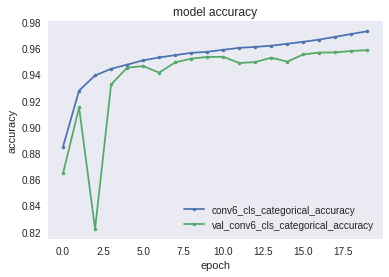

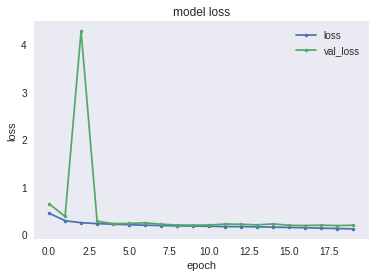

In [29]:
plot_history(history)

In [0]:
save_history(history)

In [31]:
!cat result.txt

epoch	loss	acc	val_loss	val_acc
0	0.4500075092900804	0.8850418665470221	0.6497954451120816	0.8645729300303336
1	0.2925178110599518	0.9277647655088823	0.3821846223794497	0.9148815595186673
2	0.25039063492319086	0.9393209535560328	4.282272840157534	0.8221802879602481
3	0.23133327732811043	0.9443821511862479	0.2826779924142055	0.9324354773912674
4	0.2190121936274099	0.9475813010236719	0.23039868588630968	0.9452162721218207
5	0.20737723105556363	0.9508450644793528	0.23480414732908592	0.9464708964029948
6	0.19810775861198648	0.9530516015740979	0.24851787052093408	0.9414883958987701
7	0.19041581833973908	0.9548326361747015	0.21740312836109063	0.949278651139675
8	0.18376553773661672	0.9565701312197871	0.20177196157284272	0.9521796244841355
9	0.18026058359460517	0.9573688415380625	0.1995008091131846	0.953434366446275
10	0.1751887049976286	0.958896931929466	0.20102937137469268	0.9535677753962003
11	0.16874268711049914	0.9604111556168441	0.22243083746005327	0.948831000389197
12	0.167268272284623